# Maze generator

In [1]:
import numpy as np
import matplotlib.pyplot as plt

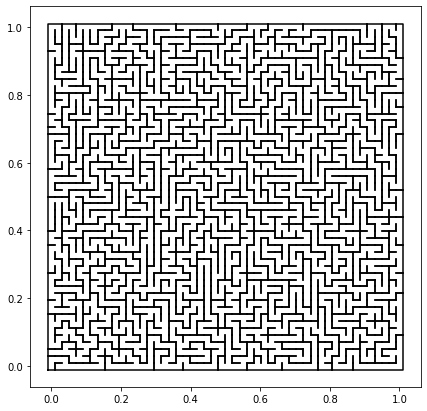

In [2]:
# Recursive solution

class Maze:
    def __init__(self, n=3):
        self.gdict = {} # Main graph
        self.n = n
        self.randperm_resource = np.random.permutation(n+1).tolist()
        for i in range(n):
            for j in range(n):
                self.gdict[(i,j)] = []
        self.trail((0,0))
                    
    def neighbors(self, pair):
        """Returns legal neighboring pairs for each pair (tuple)."""
        i,j = pair
        n = self.n
        out = []
        if i>0:   out.append((i-1,j))
        if i<n-1: out.append((i+1,j))
        if j>0:   out.append((i,j-1))
        if j<n-1: out.append((i,j+1))
        return out
    
    def gplot(self):
        """Plots underlying graph (not the maze how we typically draw them)."""
        x = np.linspace(0,1,self.n)
        for key,val in self.gdict.items():
            i1,j1 = key
            for i,j in val:
                plt.plot(x[[i1,i]], x[[j1,j]], 'b-')
                
    def plot(self):
        """Draws the maze."""
        x = np.linspace(0,1,self.n)
        pad = 1/(self.n-1)/2
        plt.plot(np.array([0, 0, 1, 1, 0])*(1+2*pad)-pad, np.array([0, 1, 1, 0, 0])*(1+2*pad)-pad, 'k-')
        for key,val in self.gdict.items():
            i1,j1 = key
            for i,j in self.neighbors(key):
                if (i,j) not in val:
                    plt.plot([(x[i1]+x[i]-x[j1]+x[j])/2, (x[i1]+x[i]+x[j1]-x[j])/2],
                             [(x[j1]+x[j]-x[i1]+x[i])/2, (x[j1]+x[j]+x[i1]-x[i])/2], 'k-')
                    
    def randperm(self,point,l):
        """A rather unsuccessful attempt to pre-calculate some randomness. 
        It's both still slow, and not random enough."""
        n = len(self.randperm_resource)
        left = (point[0]+point[1]*61) % n
        if left+l < n:
            out =  self.randperm_resource[left:left+l]
        out = self.randperm_resource[left:] + self.randperm_resource[:l-(n-left)]
        return [i for _,i in sorted([(out[j],j) for j in range(l)])]
                
    def trail(self, point, visited=None):
        """Making the actual maze, recursively."""
        if visited is None:
            visited = {key:False for key,_ in self.gdict.items()}
        visited[point] = True
        nei = self.neighbors(point)
        if True:
            nei = [nei[i] for i in np.random.permutation(len(nei))] 
            # Slowest part of the entire script (30% of time)
        else:
            # Rather unsuccessful attempt to front-order randomness
            nei = [nei[i] for i in self.randperm(point,len(nei))] # Faster?
        while nei:
            p = nei.pop()
            if not visited[p]:
                self.gdict[point].append(p)
                self.gdict[p].append(point)
                self.trail(p, visited)
        return
                
#%prun 
maze = Maze(50) # Doesn't work with n=100 (recursion depth error)
fig = plt.figure(figsize=(7,7))
maze.plot()
#maze.gplot() # paths

Built, now plotting...


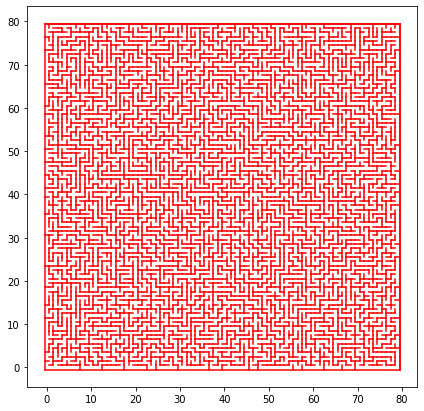

In [107]:
# Queue solution

class Mazeq:
    def __init__(self, n=3):
        self.n = n
        self.nodes = [(i,j) for i in range(n) for j in range(n)]
        self.edges = set()
        """for i,j in self.nodes:
            if i < n-1:
                self.edges.add(( (i,j) , (i+1,j) ))
            if j < n-1:
                self.edges.add(( (i,j) , (i,j+1) ))"""
        self._build() # Build the actual maze
    
    def _neighbors(self, node):
        i,j = node
        out = []
        if i>0:         out += [(i-1,j)]
        if j>0:         out += [(i,j-1)]
        if i<self.n-1:  out += [(i+1,j)]
        if j<self.n-1:  out += [(i,j+1)]
        return out
    
    def _build(self):
        """Starting from (0,0), build the actual maze."""
        visited = set()
        queue = [(self.n // 2, self.n // 2)] # Queue of nodes to visit
        visited.add(queue[0])
        while queue:
            node = queue.pop()
            neighbors = [other for other in self._neighbors(node) if other not in visited]
            if not neighbors:
                continue
            if len(neighbors)==1:
                other = neighbors[0]
            else:
                queue.append(node) # But back, we're not done yet
                other = neighbors[np.random.randint(len(neighbors))]                
            queue.append(other)
            visited.add(other)
            self.edges.add((node, other))
            self.edges.add((other, node))            
        
    def report(self):
        print(self.nodes)
        
    def plot(self, inner=True):
        """Plot the underlying graph instead of plotting the maze"""
        plt.figure(figsize=(7,7))
        if inner:
            for node in self.nodes:
                plt.plot(node[0], node[1], '.', color='blue')
        for i in range(self.n):
            for j in range(self.n):
                node = (i,j)
                for other in [(i+1,j), (i,j+1)]:
                    if (node,other) not in self.edges:
                        plt.plot([(node[0]+other[0]+other[1]-node[1])/2, (node[0]+other[0]-other[1]+node[1])/2],
                                 [(node[1]+other[1]+other[0]-node[0])/2, (node[1]+other[1]-other[0]+node[0])/2],
                                 '-', color='red')
                    else:
                        if inner:
                            plt.plot([node[0], other[0]], [node[1], other[1]], '-', color='teal')
        def _rect(p1, p2, style, color):
            x,y = p1
            v,w = p2
            plt.plot([x,x], [y,w], style, color=color)
            plt.plot([x,v], [w,w], style, color=color)
            plt.plot([v,v], [y,w], style, color=color)
            plt.plot([x,v], [y,y], style, color=color)
        
        _rect((-0.5, -0.5), (self.n-0.5, self.n-0.5), style='-', color='red')
        return         
       
# Test
    
#%prun
maze = Mazeq(80)
print('Built, now plotting...')
maze.plot(inner=False)